In [1]:
import numpy as np
from scipy.linalg import khatri_rao
import matplotlib.pyplot as plt

## Tensor unfolding 
Mode-0, Mode-1, Mode-2 Unfolding

In [31]:
class unfold_Tensor():
    def mode_zero_unfold(self, tensor):
        new_matrix = tensor[0]
        number, _, _ = tensor.shape
        for i in range(1, number):
             new_matrix = np.hstack((new_matrix, tensor[i]))
        return new_matrix

    def mode_one_unfold(self, tensor):
        new_matrix = tensor[0].T
        number, _, _ = tensor.shape
        for i in range(1, number):
             new_matrix = np.hstack((new_matrix, tensor[i].T))
        return new_matrix

    def mode_two_unfold(self, tensor):
        new_matrix = tensor[0].T.flatten()
        number, _, _ = tensor.shape
        for i in range(1, number):
            new_matrix = np.vstack((new_matrix, tensor[i].T.flatten()))
        return new_matrix

    def tensor_unfold(self, tensor, mode):
        unfold_tensor = None
        if mode == 0:
            unfold_tensor = self.mode_zero_unfold(tensor)
        elif mode == 1:
            unfold_tensor = self.mode_one_unfold(tensor)
        elif mode == 2:
            unfold_tensor = self.mode_two_unfold(tensor)
        else:
            print("Wrong mode value please enter mode between 0, 1 and 2 only.")
        return unfold_tensor

In [32]:
A = np.array([[[0, 2, 4, 6], [8, 10, 12, 14], [16, 18, 20, 22]], 
              [[1, 3, 5, 7], [9, 11, 13, 15], [17, 19, 21, 23]]])
u = unfold_Tensor()
print("Tensor [frontal slices]: ")
print(A)
print()
X_0 = u.tensor_unfold(A, 0)
print("Mode-0 unfolding...")
print(X_0)
print()
X_1 = u.tensor_unfold(A, 1)
print("Mode-1 unfolding...")
print(X_1)
print()
X_2 = u.tensor_unfold(A, 2)
print("Mode-2 unfolding...")
print(X_2)

Tensor [frontal slices]: 
[[[ 0  2  4  6]
  [ 8 10 12 14]
  [16 18 20 22]]

 [[ 1  3  5  7]
  [ 9 11 13 15]
  [17 19 21 23]]]

Mode-0 unfolding...
[[ 0  2  4  6  1  3  5  7]
 [ 8 10 12 14  9 11 13 15]
 [16 18 20 22 17 19 21 23]]

Mode-1 unfolding...
[[ 0  8 16  1  9 17]
 [ 2 10 18  3 11 19]
 [ 4 12 20  5 13 21]
 [ 6 14 22  7 15 23]]

Mode-2 unfolding...
[[ 0  8 16  2 10 18  4 12 20  6 14 22]
 [ 1  9 17  3 11 19  5 13 21  7 15 23]]


## CANDECOMP/PARAFAC Decomposition:

In [36]:
def reconstruct_estimation_tensor(a, b, c, input_shape):
    M = np.zeros(input_shape)
    if a.shape[1] == b.shape[1] == c.shape[1]:
        pass
    else:
        print("Columns of a, b, c matrices must be equal")
        return None
    for col_index in range(0, a.shape[1]):
        a_tilde = np.asarray([a[:, col_index]]).T
        b_tilde = np.asarray([b[:, col_index]]).T
        c_tilde = np.asarray([c[:, col_index]]).T
        result_1 = khatri_rao(a_tilde, b_tilde)
        result_2 = khatri_rao(result_1,c_tilde)
        result_2 = np.reshape(result_2, input_shape)
        M += result_2
    return M
        
def CP_Decomposition(tensor, rank, max_iter):
    error = []
    u = unfold_Tensor()
    a = np.random.random((rank, tensor.shape[0]))
    b = np.random.random((rank, tensor.shape[1]))
    c = np.random.random((rank, tensor.shape[2]))

    for epoch in range(max_iter):
        input_a = khatri_rao(b.T, c.T)
        target_a = u.tensor_unfold(tensor, mode=2).T
       # print(input_a.T.dot(input_a).shape)
        #print(input_a.T.dot(target_a).shape)
        a = np.linalg.solve(input_a.T.dot(input_a), input_a.T.dot(target_a))
        input_b = khatri_rao(a.T, c.T)
        target_b = u.tensor_unfold(tensor, mode=0).T
        #print(input_b.T.dot(input_b).shape)
        #print(input_b.T.dot(target_b).shape)
        b = np.linalg.solve(input_b.T.dot(input_b), input_b.T.dot(target_b))
        input_c = khatri_rao(a.T, b.T)
        target_c = u.tensor_unfold(tensor, mode=1).T
        #print(input_c.T.dot(input_c).shape)
        #print(input_c.T.dot(target_c).shape)
        c = np.linalg.solve(input_c.T.dot(input_c), input_c.T.dot(target_c))
        M = reconstruct_estimation_tensor(a.T, b.T, c.T, tensor.shape)
        sse_error = (np.linalg.norm((tensor-M)))**2
        error.append(sse_error)
        if epoch %50 == 0:
            print("Epoch: ",epoch, "Sum of squared error: ", sse_error)
    return a.T, b.T, c.T, error

In [43]:
input_shape = (3, 6, 5)
A = np.random.random(input_shape)
max_iter = 300

Epoch:  0 Sum of squared error:  4.295690856409684
Epoch:  50 Sum of squared error:  3.9747840584975482
Epoch:  100 Sum of squared error:  3.7699370957201404
Epoch:  150 Sum of squared error:  4.131661307800996
Epoch:  200 Sum of squared error:  3.7541371484759765
Epoch:  250 Sum of squared error:  3.8383036054095006


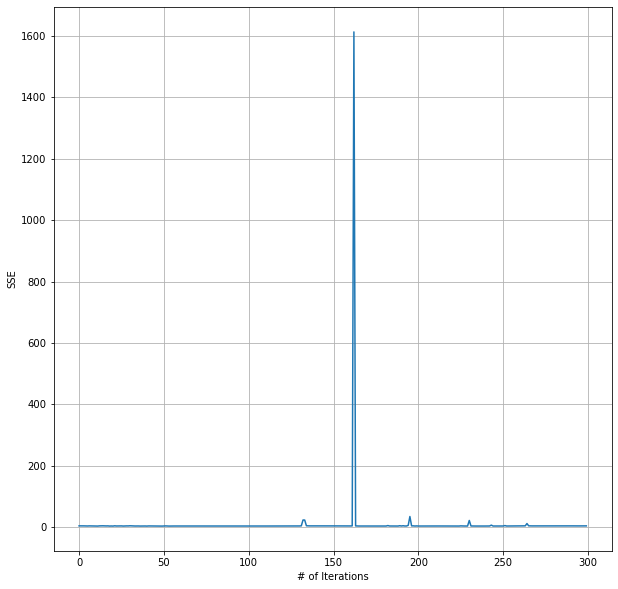

In [58]:
a, b, c, error = CP_Decomposition(A, 3, max_iter)
M = reconstruct_estimation_tensor(a, b, c, input_shape)
plt.figure(figsize=(10, 10))
plt.plot(error)
plt.grid()
plt.xlabel("# of Iterations")
plt.ylabel("SSE")
plt.show()

In [7]:
print("Difference between original and reconstructed matrix")
print(A-M)

Difference between original and reconstructed matrix
[[[ 0.05179587 -0.28683818  0.0625481   0.18149907 -0.31017774]
  [ 0.1640461  -0.13923858 -0.25478662  0.00810661 -0.07670249]
  [-0.14305685  0.15033877  0.28786657  0.20393328  0.48739423]
  [-0.21577623 -0.02818237 -0.62090459 -0.08400895  0.14672311]
  [-0.18300856  0.01058477  0.29518203 -0.21514504 -0.26427383]
  [ 0.40130244 -0.10106811 -0.0421677   0.1431782  -0.36176503]]

 [[-0.38489894  0.03685338 -0.29444482  0.25911474  0.01112754]
  [ 0.27294415 -0.16468056  0.07199505 -0.15924983  0.13048584]
  [ 0.27132277 -0.24258908  0.54750082  0.12892101  0.0387166 ]
  [ 0.16474954 -0.15824264 -0.05188902 -0.09337434  0.00981463]
  [ 0.51161431 -0.27381445  0.28228872 -0.1624814   0.12648234]
  [ 0.06855649  0.37078797  0.09096913 -0.26338422 -0.22299489]]

 [[-0.05848998  0.23345786  0.0780755  -0.18573547  0.26417519]
  [-0.35364287  0.13409175  0.19782538  0.17701692  0.21633389]
  [ 0.02414032 -0.12035562 -0.35830758 -0.39998

In [8]:
print(A)

[[[0.81234836 0.13266249 0.84907361 0.88740105 0.32551655]
  [0.96027563 0.19834951 0.43821835 0.8575058  0.33661173]
  [0.32221807 0.39636418 0.88419276 0.61691852 0.9395156 ]
  [0.30288686 0.24176597 0.09315309 0.36810744 0.67816716]
  [0.40626542 0.27753818 0.9904362  0.35704185 0.19565124]
  [0.91632511 0.16978995 0.47148695 0.63602174 0.03451638]]

 [[0.39763814 0.79921448 0.05977835 0.83358772 0.87449248]
  [0.77914866 0.14897888 0.29050709 0.35553584 0.39624612]
  [0.7132173  0.15191899 0.92975893 0.43853678 0.59577367]
  [0.64231289 0.25192867 0.44504175 0.2341385  0.64440748]
  [0.93381212 0.01340268 0.69569485 0.19226636 0.54961696]
  [0.55781052 0.82434614 0.3082169  0.11486865 0.27716798]]

 [[0.71318273 0.69852131 0.8355679  0.5091507  0.94365429]
  [0.41121458 0.46941718 0.82412868 0.99359317 0.60351149]
  [0.49401143 0.1476373  0.23878797 0.00297298 0.07341534]
  [0.37889411 0.51664821 0.84959311 0.70501858 0.71662518]
  [0.74201156 0.52009514 0.84946571 0.76429521 0.311

## Pytorch implementation of 3 way decomposition

In [9]:
import torch
import tensorly

In [10]:
class unfold_Tensor():
    def mode_zero_unfold(self, tensor):
        new_matrix = tensor[0]
        for i in range(1, tensor.shape[0]):
            new_matrix = torch.cat((new_matrix, tensor[i]), 1)
        return new_matrix

    def mode_one_unfold(self, tensor):
        new_matrix = tensor[0].T
        for i in range(1, tensor.shape[0]):
            new_matrix = torch.cat((new_matrix, tensor[i].T), 1)
        return new_matrix

    def mode_two_unfold(self, tensor):
        x, y, z = tensor.shape
        new_matrix = torch.flatten(tensor[0].T)
        for i in range(1, tensor.shape[0]):
            new_matrix = torch.cat((new_matrix, torch.flatten(tensor[i].T)), dim=0)
        new_matrix = torch.reshape(new_matrix, (x, y*z))
        return new_matrix

    def tensor_unfold(self, tensor, mode):
        unfold_tensor = None
        if mode == 0:
            unfold_tensor = self.mode_zero_unfold(tensor)
        elif mode == 1:
            unfold_tensor = self.mode_one_unfold(tensor)
        elif mode == 2:
            unfold_tensor = self.mode_two_unfold(tensor)
        else:
            print("Wrong mode value please enter mode between 0, 1 and 2 only.")
        return unfold_tensor

In [11]:
A = np.array([[[0, 2, 4, 6], [8, 10, 12, 14], [16, 18, 20, 22]],
              [[0, 2, 4, 6], [8, 10, 12, 14], [16, 18, 20, 22]],
              [[1, 3, 5, 7], [9, 11, 13, 15], [17, 19, 21, 23]]])
print("Type of A before conv: ", type(A))
A = torch.from_numpy(A)
print("Type of A after conv: ", type(A))
#A = torch.rand(3, 6, 5)
u = unfold_Tensor()
print("Tensor [frontal slices]: ")
print(A)
print()
X_0 = u.tensor_unfold(A, 0)
print("Mode-0 unfolding...")
print(X_0)
print()
X_1 = u.tensor_unfold(A, 1)
print("Mode-1 unfolding...")
print(X_1)
print()
X_2 = u.tensor_unfold(A, 2)
print("Mode-2 unfolding...")
print(X_2)

Type of A before conv:  <class 'numpy.ndarray'>
Type of A after conv:  <class 'torch.Tensor'>
Tensor [frontal slices]: 
tensor([[[ 0,  2,  4,  6],
         [ 8, 10, 12, 14],
         [16, 18, 20, 22]],

        [[ 0,  2,  4,  6],
         [ 8, 10, 12, 14],
         [16, 18, 20, 22]],

        [[ 1,  3,  5,  7],
         [ 9, 11, 13, 15],
         [17, 19, 21, 23]]])

Mode-0 unfolding...
tensor([[ 0,  2,  4,  6,  0,  2,  4,  6,  1,  3,  5,  7],
        [ 8, 10, 12, 14,  8, 10, 12, 14,  9, 11, 13, 15],
        [16, 18, 20, 22, 16, 18, 20, 22, 17, 19, 21, 23]])

Mode-1 unfolding...
tensor([[ 0,  8, 16,  0,  8, 16,  1,  9, 17],
        [ 2, 10, 18,  2, 10, 18,  3, 11, 19],
        [ 4, 12, 20,  4, 12, 20,  5, 13, 21],
        [ 6, 14, 22,  6, 14, 22,  7, 15, 23]])

Mode-2 unfolding...
tensor([[ 0,  8, 16,  2, 10, 18,  4, 12, 20,  6, 14, 22],
        [ 0,  8, 16,  2, 10, 18,  4, 12, 20,  6, 14, 22],
        [ 1,  9, 17,  3, 11, 19,  5, 13, 21,  7, 15, 23]])


In [23]:
def reconstruct_estimation_tensor(a, b, c, input_shape):
    M = np.zeros(input_shape)
    a = a.numpy()
    b = b.numpy()
    c = c.numpy()
    if a.shape[1] == b.shape[1] == c.shape[1]:
        pass
    else:
        print("Columns of a, b, c matrices must be equal")
        return None
    for col_index in range(0, a.shape[1]):
        a_tilde = np.asarray([a[:, col_index]]).T
        b_tilde = np.asarray([b[:, col_index]]).T
        c_tilde = np.asarray([c[:, col_index]]).T
        result_1 = khatri_rao(a_tilde, b_tilde)
        result_2 = khatri_rao(result_1,c_tilde)
        result_2 = np.reshape(result_2, input_shape)
        M += result_2
    return M
        
def CP_Decomposition(tensor, rank, max_iter):
    error = []
    u = unfold_Tensor()
    a = torch.rand((rank, tensor.shape[0]))
    b = torch.rand((rank, tensor.shape[1]))
    c = torch.rand((rank, tensor.shape[2]))

    for epoch in range(max_iter):
        input_a = khatri_rao(b.T, c.T)
        input_a = torch.from_numpy(input_a)
        target_a = u.tensor_unfold(tensor, mode=2).T
        r1 = torch.matmul(input_a.T,input_a)
        r2 = torch.matmul(input_a.T,target_a)
        a = torch.solve(r2, r1)[0]

        input_b = khatri_rao(a.T, c.T)
        input_b = torch.from_numpy(input_b)
        target_b = u.tensor_unfold(tensor, mode=0).T
        r1 = torch.matmul(input_b.T,input_b)
        r2 = torch.matmul(input_b.T,target_b)
        b = torch.solve(r2, r1)[0]

        input_c = khatri_rao(a.T, b.T)
        input_c = torch.from_numpy(input_c)
        target_c = u.tensor_unfold(tensor, mode=1).T
        r1 = torch.matmul(input_c.T,input_c)
        r2 = torch.matmul(input_c.T,target_c)
        c = torch.solve(r2, r1)[0]

        #M = reconstruct_estimation_tensor(a.T, b.T, c.T, tensor.shape)
        #M = torch.from_numpy(M)
        #sse_error = (np.linalg.norm((tensor-M)))**2
        #error.append(sse_error)
        #if epoch %50 == 0:
            #print("Epoch: ",epoch, "Sum of squared error: ", sse_error)
    return a.T, b.T, c.T, error

In [24]:
input_shape = (3, 6, 5)
torch.manual_seed(0)
A = torch.rand(input_shape)
max_iter = 1

In [25]:
a, b, c, error = CP_Decomposition(A, 3, max_iter)

In [30]:
print(a)
print(b)
print(c)

tensor([[0.8325, 0.6978, 0.6329],
        [0.6378, 0.2375, 1.1617],
        [0.7149, 1.7045, 0.5741]])
tensor([[ 0.4722,  0.5958,  0.2462],
        [ 1.3109,  0.0173,  0.1455],
        [ 0.7875,  0.1996, -0.0884],
        [ 1.0278,  0.1739, -0.0429],
        [ 1.0343,  0.1170,  0.5939],
        [ 0.5967,  0.2952,  0.0787]])
tensor([[ 0.4740,  0.5082,  0.2890],
        [ 0.5949,  0.5263,  0.9597],
        [ 0.7614, -0.1970,  0.1716],
        [ 0.4875,  0.4487,  0.2581],
        [ 0.5683,  0.3464,  0.4223]])
